# Trying out Zama's concrete API

Sources:
 * https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html (Code source: Jaques Grobler, License: BSD 3 clause)
 * https://docs.zama.ai/concrete-numpy/stable/user/advanced_examples/LinearRegression.html

## Imports and datasets

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

## Standard sklearn linear regression

In [11]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


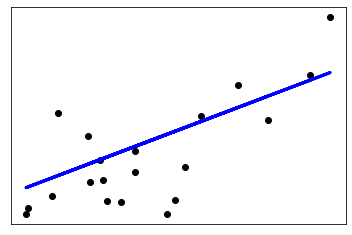

In [13]:
def results(model, X_test, y_test, y_pred) -> None:
    # The coefficients
    print("Coefficients: \n", model.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

    # Plot outputs
    plt.scatter(X_test, y_test, color="black")
    plt.plot(X_test, y_pred, color="blue", linewidth=3)

    plt.xticks(())
    plt.yticks(())

    plt.show()

results(regr, diabetes_X_test, diabetes_y_test, diabetes_y_pred)

## Using concrete from Zama

### Additional imports

In [17]:
from copy import deepcopy
from typing import Any, Dict, List

from concrete.quantization import QuantizedArray, QuantizedLinear, QuantizedModule
# import concrete.numpy as hnp

### Quantized wrapper around sklearn's linear regression model (from Zama's documentation)

In [19]:
class QuantizedLinearRegression(QuantizedModule):
    """
    Quantized Generalized Linear Model
    Building on top of QuantizedModule, this class will chain together a linear transformation
    and an inverse-link function
    """

    @staticmethod
    def from_sklearn(sklearn_model, calibration_data):
        """Create a Quantized Linear Regression initialized from a sklearn trained model"""
        weights = np.expand_dims(sklearn_model.coef_, 1)
        bias = sklearn_model.intercept_
        #Quantize with 6 bits for input data, 1 for weights, 1 for the bias and 6 for the output
        return QuantizedLinearRegression(6, 1, 1, 6, weights, bias, calibration_data)

    def __init__(self, q_bits, w_bits, b_bits, out_bits, weights, bias, calibration_data) -> None:
        """
        Create the Linear regression with different quantization bit precitions:

        Quantization Parameters - Number of bits:
            q_bits (int): bits for input data, insuring that the number of bits of
                        the w . x + b operation does not exceed 7 for the calibration data
            w_bits (int): bits for weights: in the case of a univariate regression this
                        can be 1
            b_bits (int): bits for bias (this is a single value so a single bit is enough)
            out_bits (int): bits for the result of the linear transformation (w.x + b).
                            In our case since the result of the linear transformation is
                            directly decripted we can use the maximum of 7 bits

        Other parameters:
            weights: a numpy nd-array of weights (Nxd) where d is the data dimensionality
            bias: a numpy scalar
            calibration_data: a numpy nd-array of data (Nxd)
        """
        self.n_bits = out_bits

        # We need to calibrate to a sufficiently low number of bits
        # so that the output of the Linear layer (w . x + b)
        # does not exceed 7 bits
        self.q_calibration_data = QuantizedArray(q_bits, calibration_data)

        # Quantize the weights and create the quantized linear layer
        q_weights = QuantizedArray(w_bits, weights)
        q_bias = QuantizedArray(b_bits, bias)
        q_layer = QuantizedLinear(out_bits, q_weights, q_bias)

        # Store quantized layers
        quant_layers_dict: Dict[str, Any] = {}

        # Calibrate the linear layer and obtain calibration_data for the next layers
        calibration_data = self._calibrate_and_store_layers_activation(
            "linear", q_layer, calibration_data, quant_layers_dict
        )

        # Finally construct our Module using the quantized layers
        super().__init__(quant_layers_dict)

    def _calibrate_and_store_layers_activation(
        self, name, q_function, calibration_data, quant_layers_dict
    ):
        """
        This function calibrates a layer of a quantized module (e.g. linear, inverse-link,
        activation, etc) by looking at the input data, then computes the output of the quantized
        version of the layer to be used as input to the following layers
        """

        # Calibrate the output of the layer
        q_function.calibrate(calibration_data)
        # Store the learned quantized layer
        quant_layers_dict[name] = q_function
        # Create new calibration data (output of the previous layer)
        q_calibration_data = QuantizedArray(self.n_bits, calibration_data)
        # Dequantize to have the value in clear and ready for next calibration
        return q_function(q_calibration_data).dequant()

    def quantize_input(self, values):
        """Quantize an input set with the quantization parameters determined from calibration"""
        q_input_arr = deepcopy(self.q_calibration_data)
        q_input_arr.update_values(values)
        return q_input_arr

In [14]:
# Only using train data
q_linreg = QuantizedLinearRegression.from_sklearn(regr, diabetes_X_train)

# Quantize X
diabetes_X_q = q_linreg.quantize_input(diabetes_X_train)
diabetes_X_test_q = q_linreg.quantize_input(diabetes_X_test)

# Compile model
engine = q_linreg.compile(diabetes_X_q)


# Now predict using the FHE quantized model on the testing set
diabetes_y_test_pred_fhe = np.zeros_like(diabetes_X_test)

for i, x_i in enumerate(diabetes_X_test_q.qvalues):
    q_sample = np.expand_dims(x_i, 1).transpose([1, 0]).astype(np.uint8)
    q_pred_fhe = engine.run(q_sample)
    diabetes_y_test_pred_fhe[i] = q_linreg.dequantize_output(q_pred_fhe)

In [16]:
# Measure the error for the two versions of the classifier
sklearn_r2 = r2_score(diabetes_y_pred, diabetes_y_test)
homomorphic_test_error = r2_score(diabetes_y_test_pred_fhe, diabetes_y_test)

# Measure the error of the FHE quantized model w.r.t the sklearn model
difference = (
    abs(homomorphic_test_error - sklearn_r2) * 100 / sklearn_r2
)


print(f"Sklearn R^2: {sklearn_r2:.4f}")
print(f"Homomorphic R^2: {homomorphic_test_error:.4f}")
print(f"Relative Difference Percentage: {difference:.2f}%")

Sklearn R^2: -0.3708
Homomorphic R^2: -0.3373
Relative Difference Percentage: -9.06%


<Figure size 432x288 with 0 Axes>

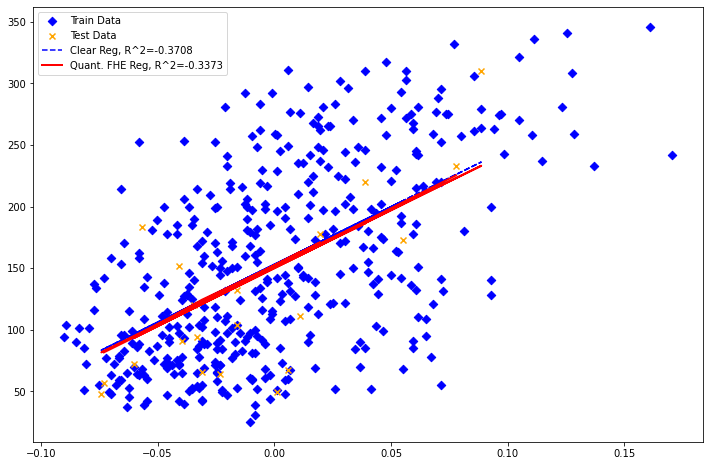

In [18]:
def compare_results(x_train, y_train, x_test, y_test, y_pred: List) -> None:
    plt.clf()
    fig, ax = plt.subplots(1, figsize=(12,8))
    fig.patch.set_facecolor("white")
    s1 = ax.scatter(x_train, y_train, c="blue", marker="D")
    s2 = ax.scatter(x_test, y_test, c="orange", marker="x")
    p1 = ax.plot(x_test, y_pred[0], c="blue", marker=None, linestyle="dashed")
    p2 = ax.plot(x_test, y_pred[1], c="red", marker=None, linewidth=2)
    ax.legend([s1, s2, p1[0], p2[0]],
        [
            "Train Data",
            "Test Data",
            f"Clear Reg, R^2={sklearn_r2:.4f}",
            f"Quant. FHE Reg, R^2={homomorphic_test_error:.4f}"
        ]
    )
    plt.show()

compare_results(diabetes_X_train, diabetes_y_train, diabetes_X_test, diabetes_y_test, [diabetes_y_pred, diabetes_y_test_pred_fhe])
